<a href="https://colab.research.google.com/github/zjay1995/Computational_Robotics/blob/master/pset3/pset3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EE209AS Pset3
The goal of this lab is to explore Kalman Filtering (KF) to estimate the state of a simple two-wheeled robot. You
will develop and implement a mathematical model of the robot sensor and actuator behavior and use it to evaluate
a state estimation algorithm.

---


Here we considered a 2 wheeled robot similar to the one shown in Fig. 1. It has two wheels of radius r = 20mm,
separated by a distance w = 85mm. It drags a tail for stability.
Each wheel is powered independently by a bi-directional continuous rotation servo—part number FS90R—with
the angular velocity of the wheel controlled by a signal from the microcontroller. This allows the robot to drive
forwards or backwards at variable speed, or turn with any turning radius. There may be slippage between the wheels
and the floor; assume the resulting effective angular speed of the wheels is normal with a standard deviation of 5%
of the max motor speed.
The robot has two laser range sensors—part number VL53L0X—and an inertial measurement unit (IMU)—part
number MPU-9250. The output of these sensors will be a function of the positional state of the robot within its
environment.
The robot will be driving within a rectangular environment of length L = 750mm and width W = 500mm,
consisting of 4 walls bounding an open space.


In [0]:
import numpy as np
import sympy as sp
from math import tan,sin,cos,atan
import statistics
from numpy.random import randn
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import animation
import time
from IPython import display

#Preliminaries
0 (a). 	Link to the GitHub:
	https://github.com/zjay1995/Computational_Robotics/tree/master/pset3
  
0 (b). 	I collaborate with Chaojie Feng

0 (c).	Other source used:
https://github.com/zjay1995/Kalman-and-Bayesian-Filters-in-Python


# Mathmatical Setup
## Dynamic Model
1. Wheels radius r = 20mm, separated by a distance w = 85mm.

2. Environment of length L = 750mm and width W = 500mm.

3. The state of robot consists of the 3 DOF pose of the robot in 2D space, with velocity terms.

4. The state includes a gyro bias terms for greater accuracy.

5. Control input --> angular velocity for each wheel, for a total of 2 input variables (ul, ur).

6. Sensor output --> laser range sensors: x,y coordinates. IMU: angle of the robot.

7. Max speed for Motor FS90R = 130 RPM --> 13.6136 rad/s

The state space is construct with following variable: 

*  x-coordinate
*  y-coordinate
*  theta
*  bias

The system is modeled with control noise and measurement noise.


## EKF
The EKF algorithm consists of following psuducode:
1. Predict State Estimate and Covariance Estimate

2. Move the robot

3. Make the measurement

4. Calculate measurement residual, covariance residual, and optimal Kalman Gain

5. Update State Estimate and Covariance Estimate

In [0]:
class EKFRobot:
    def __init__(self,wheelRadius = 20, wheelDistance = 85, 
                 maxMotorSpeed = 5, dt_update = 0.1, 
                 gyro_bias = 0.05):
        
        self.x = np.array([20,20,np.pi/4,gyro_bias])
        self.u = np.array([0,0])

        x,y,theta,ul,ur,r,d,time,bias= sp.symbols('x,y,theta,ul,ur,r,d,time,b')
        
        # initialize parameters
        self.r = wheelRadius
        self.d = wheelDistance
        self.maxMotorSpeed = maxMotorSpeed
        self.motor_err = 0.05*self.maxMotorSpeed
        self.dt_update = dt_update
        self.std_laser = 10        # 10 mm standard deviation
        self.std_imu = 0.05       # 0.05 rad standard deviation
        self.gyro_bias = gyro_bias
        self.gyro_std = self.std_imu
        
        # compute jacobian in symbolic term
        self.f = sp.Matrix([[x+1/2*sp.cos(theta)*(ul+ur)*r*time],
                            [y+1/2*sp.sin(theta)*(ul+ur)*r*time],
                            [theta + (ur-ul)*r/d*time],
                            [bias]])
        
        
        # F_j:  partial derivative of f over state x
        # V_j:  partial derivative of f over input u
        # P:    variance-covariance matrix
        # H:    partial derivative of z over x
        # R:    sensor noise variance
        self.F_j = self.f.jacobian(sp.Matrix([x,y,theta,bias]))
        self.V_j = self.f.jacobian(sp.Matrix([ul,ur]))
        
        self.P = np.eye(4)
        self.H = np.eye(4)
        self.R = np.array([[self.std_laser**2,0,0,0],
                           [0,self.std_laser**2,0,0],
                           [0,0,self.std_imu**2,0],
                           [0,0,0,self.gyro_std**2]])
        
        self.subs = {x:  self.x[0],  y: self.x[1], theta: self.x[2], 
                     ul: self.u[0], ur: self.u[1], r:self.r, d:self.d, 
                     time:self.dt_update, bias:self.gyro_bias}
        
        
        # save necessary parameters as instances for later update
        self.theta = theta
        self.ul = ul
        self.ur = ur
        
        # initialize counter
        self.ct = 0

        
    def predict(self,u=0):
        """
        Args:
          u: Input Control
        Return:
          x: state after move
          F: Jacobian matrix of state
          V: Jacobian matrix of input control parameters
          M: covariance matrix of input control parameter
          P: variance - covariance matrix
        """
        self.x = self.move(self.x,self.dt_update,u)

        self.subs[self.theta] = self.x[2]
        self.subs[self.ul] = u[0]
        self.subs[self.ur] = u[1]
        
        # updates on F, V and M
        F = np.array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = np.array(self.V_j.evalf(subs=self.subs)).astype(float)
        
        # covariance of motion noise in control space
        M = np.array([[(self.motor_err)**2, 0], 
                      [0, (self.motor_err)**2]])
        
        self.P = np.dot(F, self.P).dot(F.T) + np.dot(V, M).dot(V.T)
        
        self.ct += 1
    
    
    def move(self,x,dt,u):
        """
        Args:
          x: state space before move
          dt: time step
          u: input control
        
        Returns:
          x: state space after move
        """
      
        lws = u[0]*self.r
        rws = u[1]*self.r
        vel = (lws+rws)/2
        lwd = lws*dt
        rwd = rws*dt
        
        dx0 = cos(x[2])*vel*dt
        dx1 = sin(x[2])*vel*dt
        dx2 = (rwd-lwd)/self.d
        dx3 = 0
        
        du  = np.array((dx0,dx1,dx2,dx3))
        
        return x+du

      
    def measure(self,x):
        """       
        Args: 
          x: state variable specified by numpy(xpos, ypos, heading, bias)
        
        Returns:
          z: measurements given by sensor
        """
    
        x_e = np.sqrt(self.R).dot(randn(4))
        z = x + x_e 
    
        return z
    
    
    def residual(self,z):
        """       
        Args: 
          z: measurements given by sensor
        
        Returns:
          y: residual between measurement and expectation
        """
        y = z - self.measure(self.x)
        return y

      
    def update(self,y):
        """      
        Args:
          y: residual
        
        Returns:
          K: Kalman gain
          P: posteriori covariance matrix
          x: posteriori state
        """
        K1 = np.dot(self.P,self.H.T)
        K2 = inv(np.dot(self.H,self.P).dot(self.H.T)+self.R)
        self.K = K1.dot(K2)
        self.x = self.x + self.K.dot(y)
        self.P = (np.eye(4)-self.K.dot(self.H)).dot(self.P)

# Evaluation

EKF standard deviation: 1.169414809828288  mm


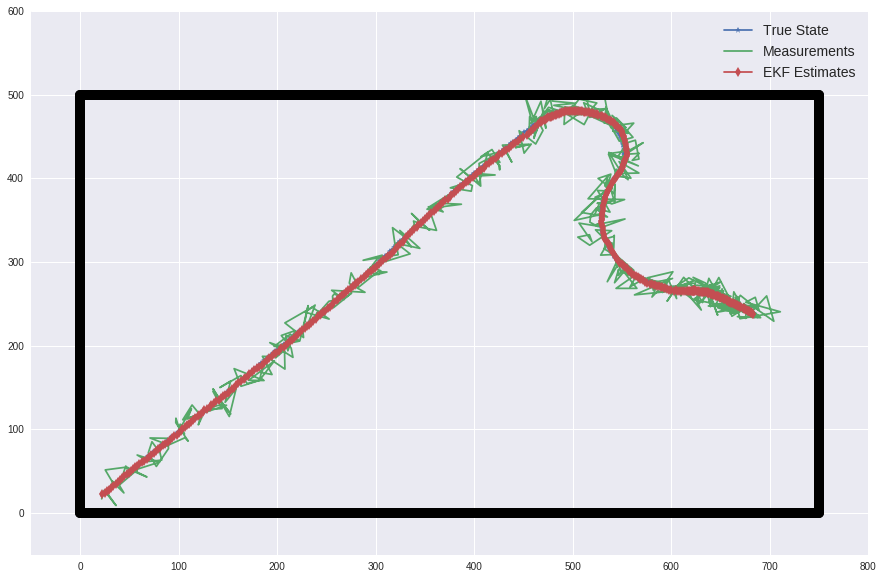

In [3]:
def run_simulation(EKFRobot,T):
    
    """
    run simulation based on robot object passed in. Animation mode is set defaultly to be true
    
    Args:
      EKFRobot: Robot object
      T: total simulation time
    
    Returns:
      The acutual trajectory and state trajectory estimated by EKF
    """
        
    # initialize movement updating interval and input parameter
    dt = 0.1
    u = np.array((np.pi/2,np.pi/2))
    
    # initialize DOG as my robot
    DOG = EKFRobot()
    dt_update = DOG.dt_update
    step = dt_update/dt
    x = DOG.x
    e = DOG.motor_err
    
    x_traj = []
    y_traj = []
    x_priori = []
    y_priori = []
    x_post = []
    y_post = []
    x_measure = []
    y_measure = []
    
    
    for i in range(0,int(T/dt)+1):
        
        # simulate for different speed
        if i >= 200:
            u = np.array([1.4,0.1])
        if i >= 300:
            u = np.array([0.5,1.4])
        if i >= 400:
            u = np.array([0.5,0.2])

        
        # make actual movement
        u_actual = u + e*randn(2)
        x = DOG.move(x,dt,u_actual)
        x_traj.append(x[0])
        y_traj.append(x[1])
        
        # activate EKF for every step
        if i % step == 0:
            
            DOG.predict(u)
            x_priori.append(DOG.x[0])
            y_priori.append(DOG.x[1])
            
            z = DOG.measure(x)
            x_measure.append(z[0])
            y_measure.append(z[1])
            y = DOG.residual(z)
            
            DOG.update(y)
            x_post.append(DOG.x[0])
            y_post.append(DOG.x[1])
           
    if i == T/dt:
        plt.figure(figsize = (15,10))
        plt.grid(True)
        plt.xlim((-50,800))
        plt.ylim((-50,600))        
        plt.plot(x_traj,y_traj,marker = '*') 
        plt.plot(x_measure,y_measure, marker = 'x')
        plt.plot(x_post,y_post, marker = 'd')
        plt.legend(['True State','Measurements','EKF Estimates'],fontsize = 14)
        L = 750
        W = 500
        plt.plot([0,0],[0,W],'k',linewidth = '10')
        plt.plot([0,L],[0,0],'k',linewidth = '10')
        plt.plot([L,L],[0,W],'k',linewidth = '10')
        plt.plot([0,L],[W,W],'k',linewidth = '10')
    # Compute std
    
    x_diff = np.array(x_traj)-np.array(x_post)
    y_diff = np.array(y_traj)-np.array(y_post)
    x_dif2 = [x**2 for x in x_diff]
    y_dif2 = [y**2 for y in y_diff]
    diff2 = np.array(x_dif2)+np.array(y_dif2)
    diff = [np.sqrt(x) for x in diff2]
    print('EKF standard deviation:', np.std(diff),' mm')
    
# run simulation
run_simulation(EKFRobot,50)

# Conclusions
The problem of EKF is that in general it is not an optimal estimator. And the estimated covariance matrix tends to underestimate the true covariance matrix. However, in this case, because the process is modeled correctly and the initial estiamte of the state is correct, the EKF give a reasonable performance: the standard deviation is only 1.2 mm and we can observe that the Estimates pretty much overlay the True trajectory.
